In [2]:
from bs4 import BeautifulSoup
#from urllib.request import urlopen
import pandas as pd
import numpy as np
import requests

from sklearn.metrics.pairwise import pairwise_distances

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

# https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [241]:
# Get games data:
top_games = pd.read_csv('../Alex/TopGames.csv')

top_games.sample(5)

,Ranking,Name,App_id,Current Players,Peak Players,Hours Played
5360,5360,001 Game Creator,347400,4,17,5688
9080,9080,Nancy Drew: The Captive Curse,42220,1,15,2949
1010,1010,Killing Floor,1250,147,523,199999
547,547,Underworld Idle,1540960,413,747,88233
8013,8013,Laid-Back Camp - Virtual - Fumoto Campsite,1514370,1,5,426


In [53]:
# Get time series data:
data = pd.read_csv('GamesDataAll.csv')

# Make percentile into number and clear "-"
data = data.replace(to_replace='%', value='', regex=True).replace({'-':'NaN'})#.replace(to_replace='Inf', value=+100, regex=True)
#data['Perc_Gain'] = data['Perc_Gain']/100

data.head()

,App_id,Name,Avg_Players,Gain,Perc_Gain,Peak_Players,Last 30 Days,April 2021,March 2021,February 2021,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
0,730,Counter-Strike: Global Offensive,1,0,0,0,695044.47,723346.52,740927.82,741013.24,...,16006.0,15959.89,17372.73,16164.22,14079.39,14134.1,10739.48,16000.75,15475.39,932.57
1,730,Counter-Strike: Global Offensive,0,1,0,0,-28302.0,-17581.31,-85.42,-2196.42,...,46.11,-1412.84,1208.51,2084.83,-54.71,3394.62,-5261.27,525.36,14542.81,NaN
2,730,Counter-Strike: Global Offensive,0,0,1,0,-3.91,-2.37,-0.01,-0.30,...,+0.29,-8.13,+7.48,+14.81,-0.39,+31.61,-32.88,+3.39,+1559.43,NaN
3,730,Counter-Strike: Global Offensive,0,0,0,1,1119102,1148077,1198581,1123485,...,31966,32166,35238,31359,27553,50533,20850,36057,52261,1642
4,570,Dota 2,1,0,0,0,413025.27,413784.97,390412.76,404832.13,...,174835.73,180878.9,166972.97,147748.14,121924.42,101077.43,75965.44,61867.68,55768.61,52721.05


In [79]:
# Get Perc_Gain and change data to float.
p_gain = data.loc[data['Perc_Gain']==1]
p_gain = p_gain.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

p_gain.sample(5)

,April 2021,March 2021,February 2021,January 2021,December 2020,November 2020,October 2020,September 2020,August 2020,July 2020,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
23846,39.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16990,-35.89,-46.31,111.53,-45.65,90.71,5.26,-36.16,-41.16,63.19,29.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31966,20.95,-67.78,4.92,28.87,-27.83,71.31,-26.05,-27.21,-35.19,41.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37274,49.85,144.85,270.95,-78.43,-15.05,-34.60,38.68,98.29,-50.32,-53.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202,11.73,-0.40,-16.20,20.37,28.16,39.96,-12.97,-8.22,-17.02,43.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [379]:
# Get Avg_Players.
avg_players = data.loc[data['Avg_Players']==1]
avg_pure = avg_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

avg_players.sample(5)

,App_id,Name,Avg_Players,Gain,Perc_Gain,Peak_Players,Last 30 Days,April 2021,March 2021,February 2021,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
4492,1211630,The Jackbox Party Pack 7,1,0,0,0,302.31,317.07,347.39,449.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992,227940,Heroes & Generals,1,0,0,0,2002.24,2259.19,2401.96,2637.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14848,1100830,BIOHAZARD RE:3 Z Version,1,0,0,0,13.81,12.79,7.73,12.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10928,47400,Stronghold 3,1,0,0,0,25.69,30.8,35.71,38.15,...,160.53,134.74,135.47,201.56,307.63,128.64,132.64,149.09,180.28,321.49
40180,1104240,Knights of the Chalice Demo,1,0,0,0,0.02,0.22,0.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [215]:
avg_pure['max'] = avg_pure.max(axis=1)
avg_pure.sort_values(by=['max'], ascending=False, inplace=True)#.reset_index(drop=True)

avg_max = avg_pure['max'].max()+1
bins = [0,50,400,3300,avg_max]
counts  = avg_pure['max'].value_counts(bins=bins, sort=False) 
#plt.scatter(bins[:-1],counts)
print(counts)
print()
print('Using maximum of Avg_Players:')
for i in [100,500,2000,5000]:
    print('The cutoff for top '+str(i)+' games is '+str(avg_pure.reset_index(drop=True)['max'][i]))

(-0.001, 50.0]          4726
(50.0, 400.0]           2984
(400.0, 3300.0]         1487
(3300.0, 1584887.77]     499
Name: max, dtype: int64

Using maximum of Avg_Players:
The cutoff for top 100 games is 24820.66
The cutoff for top 500 games is 3291.5
The cutoff for top 2000 games is 395.07
The cutoff for top 5000 games is 49.52


In [357]:
# Get Peak_Players.
peak_players = data.loc[data['Peak_Players']==1]
peak_pure = peak_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

peak_pure['max'] = peak_pure.max(axis=1)
peak_pure.sort_values(by=['max'], ascending=False, inplace=True)

peak_pure.sample(5)

,April 2021,March 2021,February 2021,January 2021,December 2020,November 2020,October 2020,September 2020,August 2020,July 2020,...,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012,max
33099,19.0,7.0,11.0,13.0,13.0,11.0,7.0,10.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.0
16639,5.0,9.0,72.0,27.0,21.0,5.0,31.0,25.0,66.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,291.0
24611,24.0,27.0,22.0,25.0,27.0,23.0,21.0,17.0,15.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
13631,48.0,35.0,50.0,52.0,25.0,30.0,35.0,41.0,36.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0
30875,3.0,4.0,3.0,2.0,2.0,2.0,1.0,3.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0


In [217]:
peak_max = peak_pure['max'].max()+1
bins = [0,50,400,4000,peak_max]
counts  = peak_pure['max'].value_counts(bins=bins, sort=False) 
#plt.scatter(bins[:-1],counts)
print(counts)
print()
print('Using maximum of Peak_Players:')
for i in [100,500,2000,5000]:
    print('The cutoff for top '+str(i)+' games is '+str(peak_pure.reset_index(drop=True)['max'][i]))

(-0.001, 50.0]         2481
(50.0, 400.0]          3251
(400.0, 4000.0]        2839
(4000.0, 3236028.0]    1125
Name: max, dtype: int64

Using maximum of Peak_Players:
The cutoff for top 100 games is 73750.0
The cutoff for top 500 games is 11878.0
The cutoff for top 2000 games is 1665.0
The cutoff for top 5000 games is 212.0


In [219]:
avg_max = np.array(avg_pure['max'])

#a = np.log(avg_max)

plt.figure(figsize=(12,12))
plt.scatter(range(len(avg_max)),avg_max[::-1])

In [232]:
s_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
ma_scaler = MaxAbsScaler()
r_scaler = RobustScaler()
qt_scaler = QuantileTransformer()
pt_scaler = PowerTransformer(method='yeo-johnson')

In [408]:
#Define a function to plot different scaling of data

def scale_data(df, games,title=None, original =True):
    
    df_data = df.drop(columns=['Name'])#.reset_index(drop=True)
    
    fig, ax = plt.subplots(3,3,figsize=(30,30))
    
    if original:
    #Plot original data
        for i in games:
            ax[0,0].plot(df_data.iloc[i][::-1].astype(float)/(1e6),label=df.Name[i])
            ax[0,0].legend() 
            ax[0,0].set_title(str(title))
        
    j=0
    #Scale data and plot
    for name,scaler in (["s_scaler",s_scaler],["mm_scaler",mm_scaler],
                 ["ma_scaler",ma_scaler]):
        scaler.fit(df_data)
        df_scaler = scaler.transform(df_data)
        for i in games:
            ax[1,j].plot(df_scaler[i][::-1]/(1e6),label=df.Name[i])
            ax[1,j].legend()
            ax[1,j].set_title(name)
        j=j+1    
        
    j=0
    #Scale data and plot
    for name,scaler in (["r_scaler",r_scaler],
                 ["qt_scaler",qt_scaler],["pt_scaler",pt_scaler]):
        scaler.fit(df_data)
        df_scaler = scaler.transform(df_data)
        for i in games:
            ax[2,j].plot(df_scaler[i][::-1]/(1e6),label=df.Name[i])
            ax[2,j].legend()
            ax[2,j].set_title(name)
        j=j+1

    plt.show()

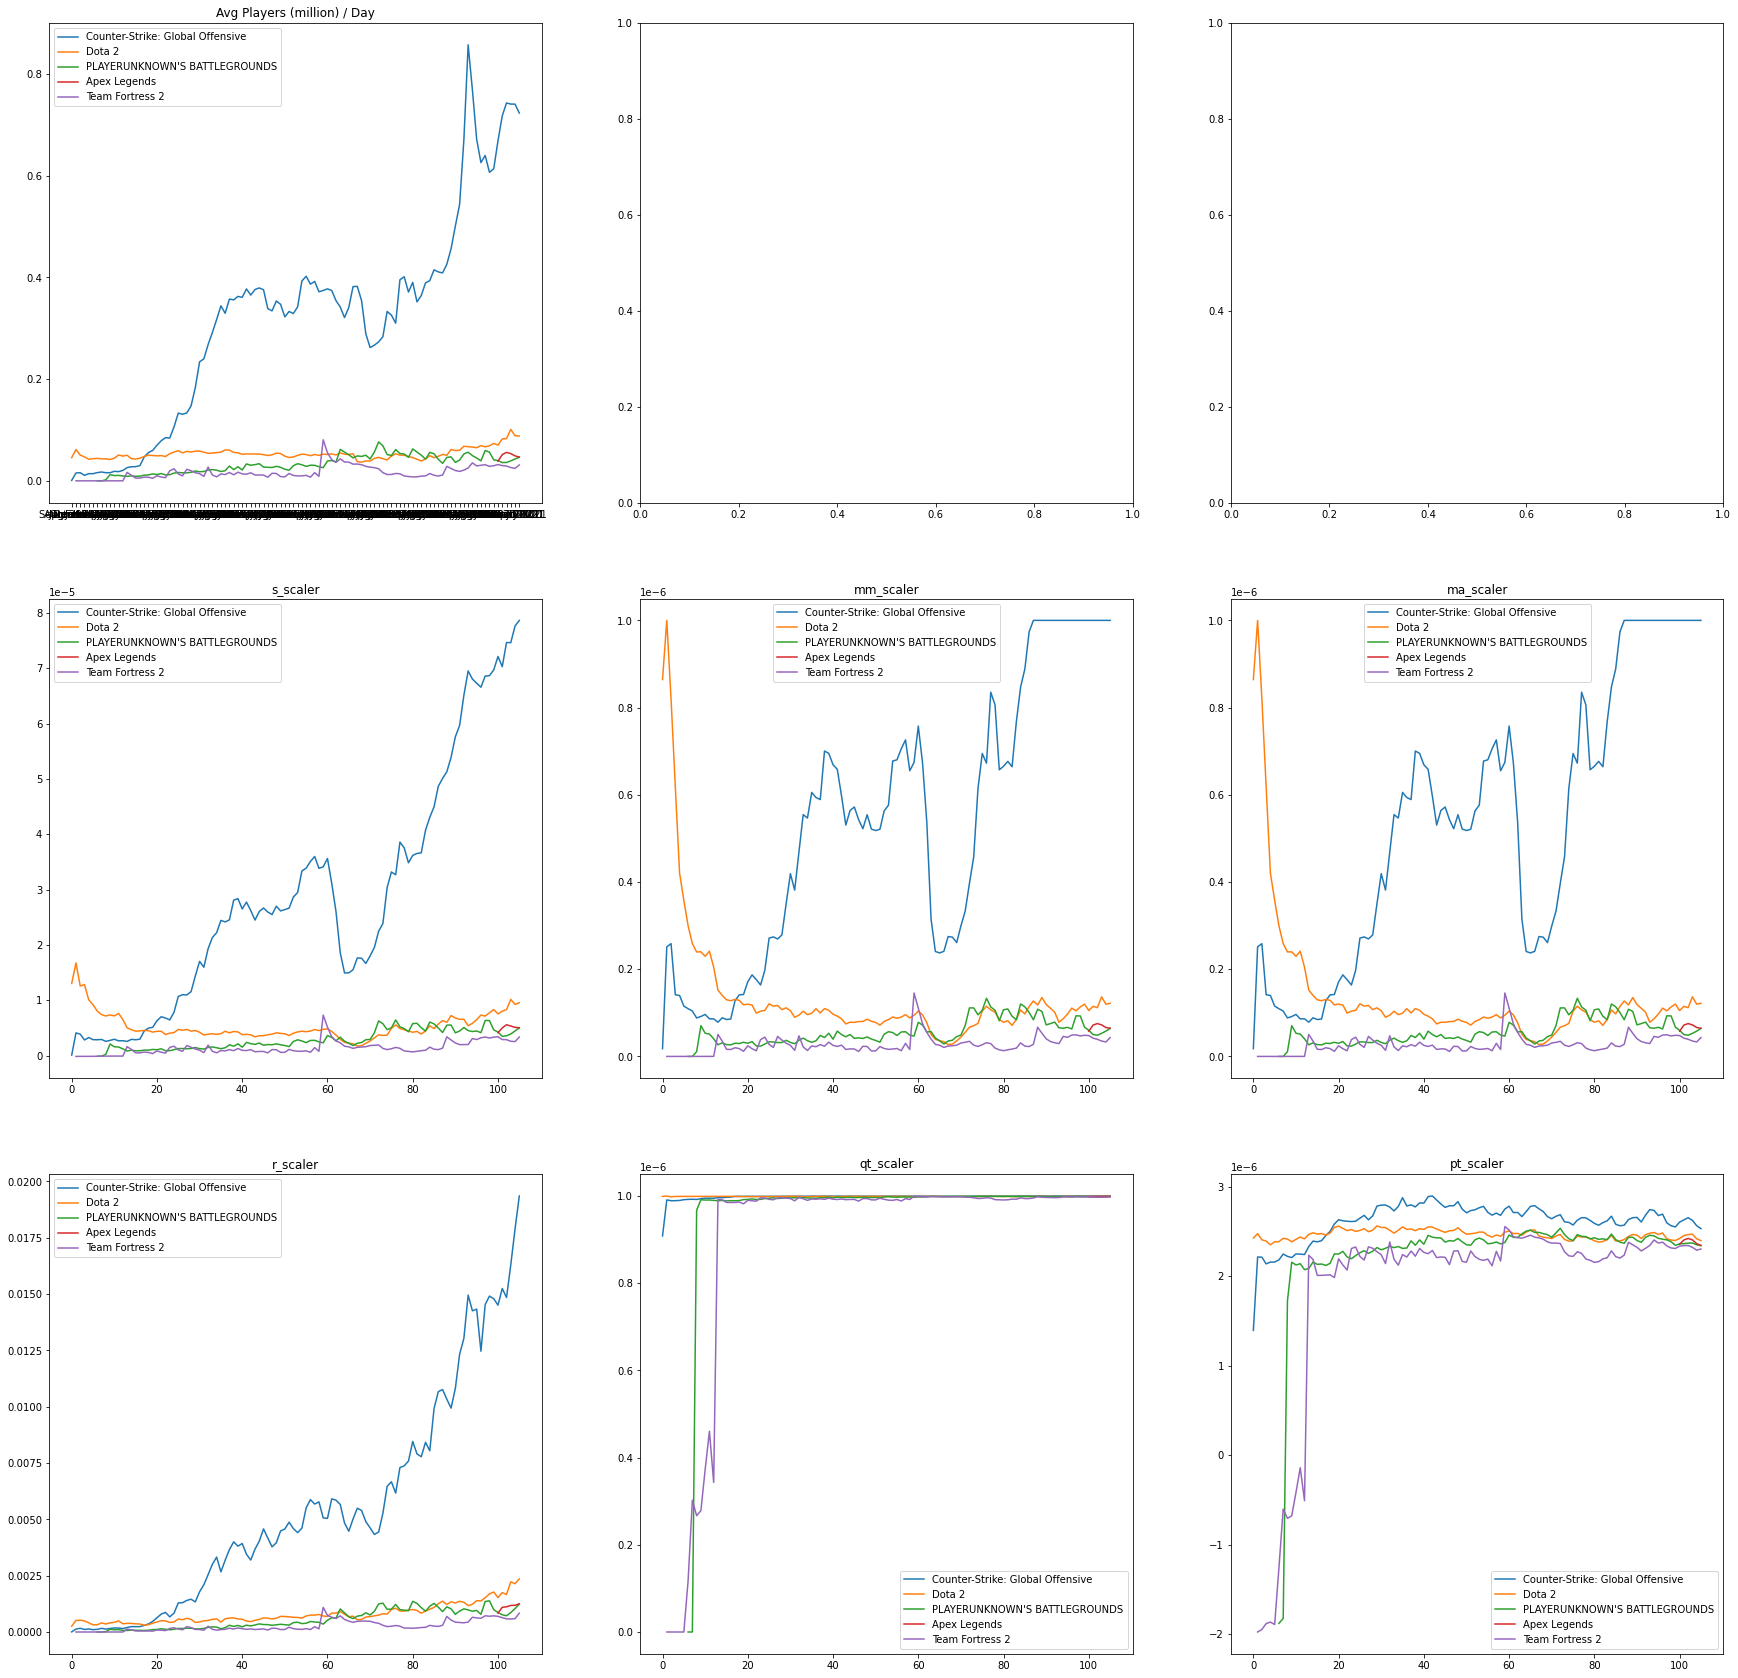

In [409]:
avg_plot = avg_players.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days'])
games = avg_players.Name[0:5].index
scale_data(avg_plot,games,title="Avg Players (million) / Day")

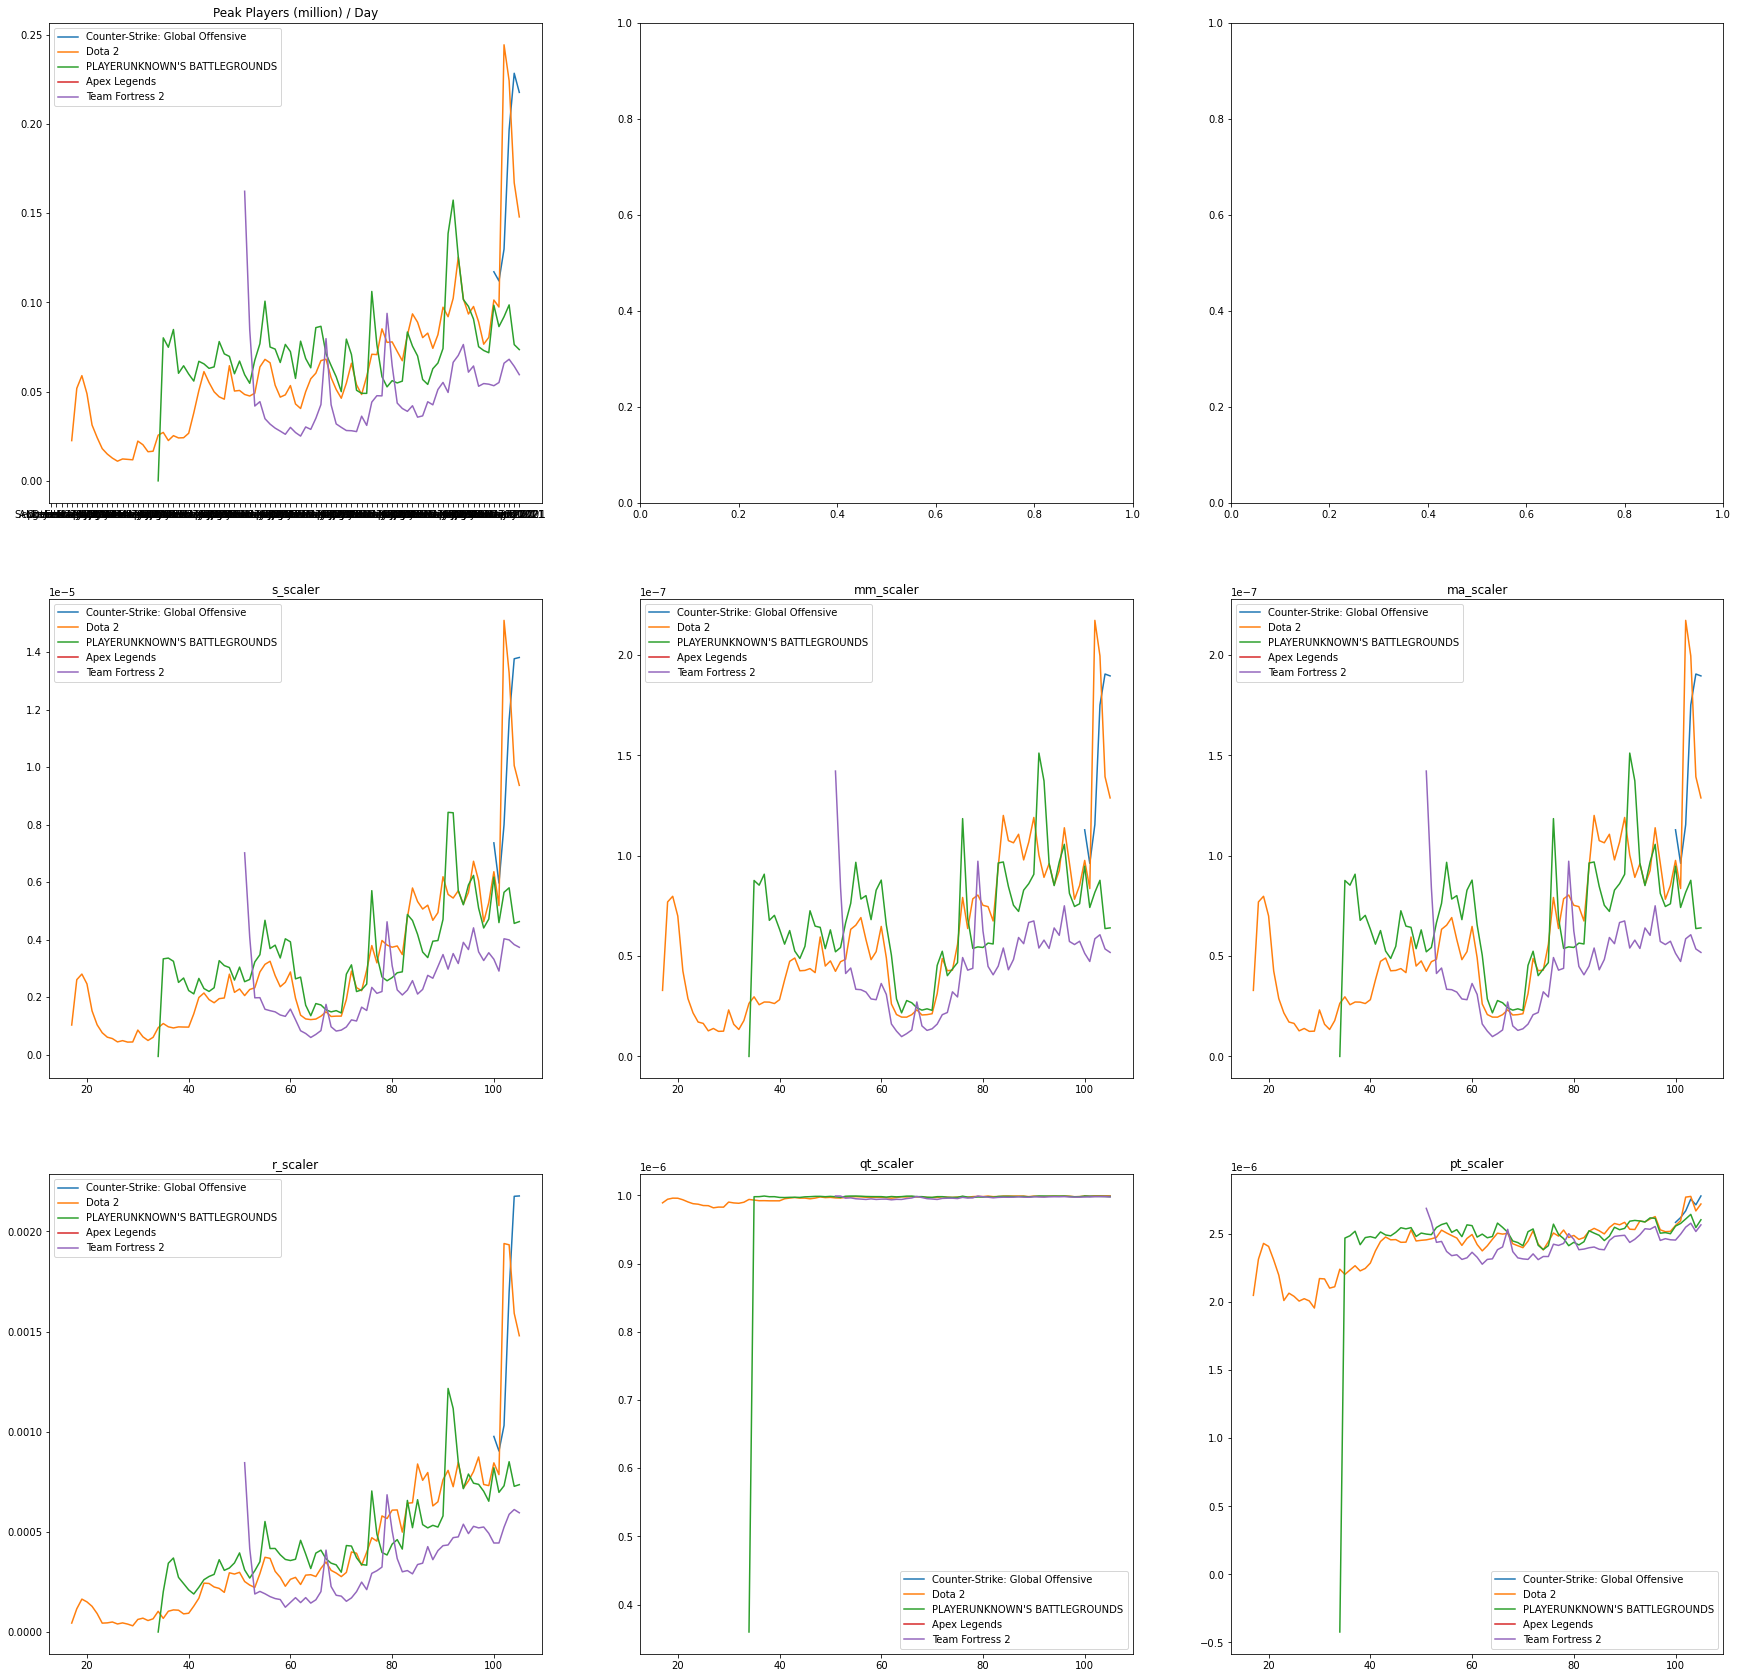

In [413]:
peak_plot = peak_players.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days'])
games = peak_players.Name[0:5].index
scale_data(peak_plot,games,title="Peak Players (million) / Day")

In [ ]:
#Define a function to plot different scaling of data

def scale_data(df, games,title=None, original =True):
#    df["mean"] = df.mean(axis=1)
#    df = df.loc[df['mean']>cutoff].reset_index(drop=True)
    df_data = df.drop(columns=['Name']).copy()
    #pd.to_datetime(df_data.columns)
    
    fig, ax = plt.subplots(3,3,figsize=(30,30))
    
    if original:
    #Plot original data
        for i in games:
            ax[0,0].plot(df_data.iloc[i][::-1].astype(float)/(1e6),label=df.Name[i])
            ax[0,0].legend() 
            ax[0,0].set_title(str(title))
        
    j=0
    #Scale data and plot
    for name,scaler in (["s_scaler",s_scaler],["mm_scaler",mm_scaler],
                 ["ma_scaler",ma_scaler]):
        scaler.fit(df_data)
        df_scaler = scaler.transform(df_data)
        for i in games:
            ax[1,j].plot(df_scaler[i][::-1]/(1e6),label=df.Name[i])
            ax[1,j].legend()
            ax[1,j].set_title(name)
        j=j+1    
        
    j=0
    #Scale data and plot
    for name,scaler in (["r_scaler",r_scaler],
                 ["qt_scaler",qt_scaler],["pt_scaler",pt_scaler]):
        scaler.fit(df_data)
        df_scaler = scaler.transform(df_data)
        for i in games:
            ax[2,j].plot(df_scaler[i][::-1]/(1e6),label=df.Name[i])
            ax[2,j].legend()
            ax[2,j].set_title(name)
        j=j+1
#    df_uvscaler = df_data.apply(lambda x:x/np.linalg.norm(x,1))
#    for i in games:
#        ax[7].plot(df_uvscaler[i][::-1]/(1e6),label=df.Name[i])
#        ax[7].legend()
#        ax[7].set_title('Unit Vector Scaler')

    plt.show()

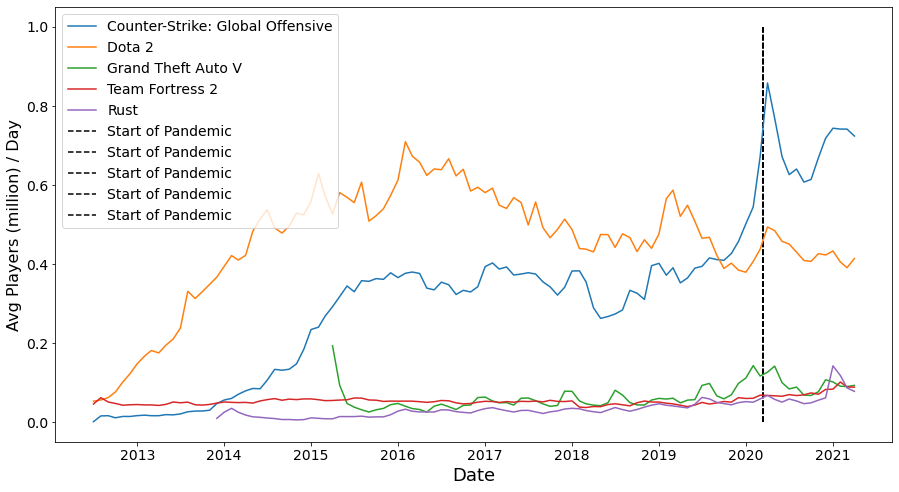

In [159]:
avg_player = pd.read_csv('../Steam Charts/avg_player.csv')
avg_player.drop_duplicates(inplace=True)
avg_player.sort_values('Last 30 Days',ascending=False,inplace=True)
plt.figure(figsize = (15,8))
for i in range(5):
    plt.plot(pd.to_datetime(avg_player.columns[3:])
             ,avg_player.iloc[i][3:]/(1e6)
             ,label=avg_player.iloc[i]['name'])
    plt.vlines(pd.to_datetime('March 11, 2020')
         ,0,1,colors='k',linestyles='dashed'
         ,label='Start of Pandemic')
plt.xlabel("Date",fontsize=18)
plt.ylabel("Avg Players (million) / Day",fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()